In [36]:
import sys
sys.path.append('../')
sys.path.append('../../')

In [37]:
# implement data collection procedure on the RTBGym environment

# import OFRL modules
import ofrl
from rtbgym import RTBEnv, CustomizedRTBEnv
from ofrl.dataset import SyntheticDataset
from ofrl.policy import OnlineHead, ContinuousEvalHead
from ofrl.policy import ContinuousTruncatedGaussianHead as TruncatedGaussianHead
from ofrl.ope.online import (
    calc_on_policy_policy_value,
    visualize_on_policy_policy_value,
)
from ofrl.utils import MinMaxScaler, MinMaxActionScaler

# import d3rlpy algorithms
from d3rlpy.algos import RandomPolicy
# from d3rlpy.preprocessing import MinMaxScaler, MinMaxActionScaler
from ofrl.utils import MinMaxScaler, MinMaxActionScaler

# import from other libraries
import gym
import torch
from sklearn.model_selection import train_test_split

In [38]:
import pickle
from glob import glob
from tqdm import tqdm

import numpy as np
import pandas as pd
from pandas import DataFrame

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [39]:
# log directory
from pathlib import Path
Path("logs/").mkdir(exist_ok=True)

In [40]:
# standardized environment for discrete action
env = gym.make("RTBEnv-continuous-v0")
# for api compatibility to d3rlpy
from ofrl.utils import OldGymAPIWrapper
env_ = OldGymAPIWrapper(env)
# behavior policy
from d3rlpy.algos import SAC
from d3rlpy.models.encoders import VectorEncoderFactory
from d3rlpy.models.q_functions import MeanQFunctionFactory
from d3rlpy.online.buffers import ReplayBuffer

# model
sac = SAC(
    actor_encoder_factory=VectorEncoderFactory(hidden_units=[30, 30]),
    critic_encoder_factory=VectorEncoderFactory(hidden_units=[30, 30]),
    q_func_factory=MeanQFunctionFactory(),
    use_gpu=torch.cuda.is_available(),
    action_scaler=MinMaxActionScaler(
        minimum=env_.action_space.low,   # 0.1
        maximum=env_.action_space.high,  # 10
    ),
)
# setup replay buffer
buffer = ReplayBuffer(
    maxlen=10000,
    env=env_,
)

In [41]:
# start training
# skip if there is a pre-trained model
sac.fit_online(
    env_,
    buffer,
    eval_env=env_,
    n_steps=1000,
    n_steps_per_epoch=10,
    update_start_step=10,
    # n_steps=100000,
    # n_steps_per_epoch=1000,
    # update_start_step=1000,
)
# save model
sac.save_model("d3rlpy_logs/sac.pt")
# reload model
sac.build_with_env(env_)
sac.load_model("d3rlpy_logs/sac.pt")

2023-03-16 10:13.06 [info     ] Directory is created at d3rlpy_logs/SAC_online_20230316101306
2023-03-16 10:13.06 [debug    ] Fitting action scaler...       action_scler=min_max
2023-03-16 10:13.06 [debug    ] Building model...
2023-03-16 10:13.06 [debug    ] Model has been built.
2023-03-16 10:13.06 [info     ] Parameters are saved to d3rlpy_logs/SAC_online_20230316101306/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'actor_encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'actor_learning_rate': 0.0003, 'actor_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'batch_size': 256, 'critic_encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense'

/Users/ren/.pyenv/versions/3.10.6/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:187: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.warn(


  0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-16 10:13.06 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20230316101306/model_10.pt
2023-03-16 10:13.06 [info     ] SAC_online_20230316101306: epoch=1 step=10 epoch=1 metrics={'time_inference': 0.0008254766464233399, 'time_environment_step': 0.00035643577575683594, 'time_step': 0.0012040138244628906, 'rollout_return': 11.0, 'evaluation': 15.5} step=10
2023-03-16 10:13.06 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20230316101306/model_20.pt
2023-03-16 10:13.06 [info     ] SAC_online_20230316101306: epoch=2 step=20 epoch=2 metrics={'time_inference': 0.0003530263900756836, 'time_environment_step': 0.00027544498443603515, 'time_step': 0.0006462574005126953, 'rollout_return': 32.0, 'evaluation': 13.7} step=20
2023-03-16 10:13.07 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20230316101306/model_30.pt
2023-03-16 10:13.07 [info     ] SAC_online_20230316101306: epoch=3 step=30 epoch=3 metrics={'time_inference': 0.000437688827

In [42]:
from d3rlpy.dataset import MDPDataset
from d3rlpy.algos import CQL

In [43]:
# import ope modules from OFRL
from ofrl.ope import CreateOPEInput
from ofrl.ope import OffPolicyEvaluation as OPE
# basic estimators
from ofrl.ope import ContinuousDirectMethod as DM
from ofrl.ope import ContinuousTrajectoryWiseImportanceSampling as TIS
from ofrl.ope import ContinuousPerDecisionImportanceSampling as PDIS
from ofrl.ope import ContinuousDoublyRobust as DR
# self normalized estimators
from ofrl.ope import ContinuousSelfNormalizedTrajectoryWiseImportanceSampling as SNTIS
from ofrl.ope import ContinuousSelfNormalizedPerDecisionImportanceSampling as SNPDIS
from ofrl.ope import ContinuousSelfNormalizedDoublyRobust as SNDR
# marginal estimators
from ofrl.ope import ContinuousStateActionMarginalImportanceSampling as SAMIS
from ofrl.ope import ContinuousStateActionMarginalDoublyRobust as SAMDR
from ofrl.ope import ContinuousStateMarginalImportanceSampling as SMIS
from ofrl.ope import ContinuousStateMarginalDoublyRobust as SMDR
from ofrl.ope import ContinuousStateActionMarginalSelfNormalizedImportanceSampling as SAMSNIS
from ofrl.ope import ContinuousStateActionMarginalSelfNormalizedDoublyRobust as SAMSNDR
from ofrl.ope import ContinuousStateMarginalSelfNormalizedImportanceSampling as SMSNIS
from ofrl.ope import ContinuousStateMarginalSelfNormalizedDoublyRobust as SMSNDR
# double reinforcement learning estimators
from ofrl.ope import ContinuousDoubleReinforcementLearning as DRL

In [44]:
basic_estimators = [DM(), TIS(), PDIS(), DR(), SNTIS(), SNPDIS(), SNDR()]
state_marginal_estimators = [SMIS(), SMDR(), SMSNIS(), SMSNDR()]
state_action_marginal_estimators = [SAMIS(), SAMDR(), SAMSNIS(), SAMSNDR()]
drl_estimators = [DRL()]
all_estimators = basic_estimators + state_marginal_estimators + state_action_marginal_estimators + drl_estimators

basic_estimators_name = ["dm", "tis", "pdis", "dr", "sntis", "snpdis", "sndr"]
state_marginal_estimators_name = ["sm_is", "sm_dr", "sm_snis", "sm_sndr"]
state_action_marginal_estimators_name = ["sam_is", "sam_dr", "sam_snis", "sam_sndr"]
drl_estimators_name = ["drl"]

In [45]:
n_trajectories_list = [100, 200, 400, 800, 1600]
# n_trajectories_list = [100, 200, 400, 800, 1600, 3200, 6400, 12800, 25600, 51200]
random_state_list = [10, 20, 30, 40, 50]
# random_state_list = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
bias_df_list = []
variance_df_list = []


In [46]:
# def cql():
#     # Use Conservative Q-Learning policy
#     cql = CQL(
#         actor_encoder_factory=VectorEncoderFactory(hidden_units=[30, 30]),
#         critic_encoder_factory=VectorEncoderFactory(hidden_units=[30, 30]),
#         q_func_factory=MeanQFunctionFactory(),
#         use_gpu=torch.cuda.is_available(),
#         action_scaler=MinMaxActionScaler(
#             minimum=env_.action_space.low,  # minimum value that policy can take
#             maximum=env_.action_space.high,  # maximum value that policy can take
#         )
#     )

#     cql.fit(
#     train_episodes,
#     eval_episodes=test_episodes,
#     n_steps=10000,
#     scorers={},

#     # save model
#     cql.save_model("d3rlpy_logs/cql_continuous.pt")

#     # reload model
#     cql.build_with_env(env)
#     cql.load_model("d3rlpy_logs/cql_continuous.pt")
# )

In [47]:

for n_trajectories in n_trajectories_list:
    # se_list = []
    for random_state in random_state_list:
    
        behavior_policy = TruncatedGaussianHead(
            sac, 
            minimum=env.action_space.low,
            maximum=env.action_space.high,
            sigma=np.array([1.0]),
            name="sac_sigma_1.0",
            random_state=random_state,
        )

        # initialize dataset class
        dataset = SyntheticDataset(
            env=env,
            state_keys=env.obs_keys,
            max_episode_steps=env.step_per_episode,
            info_keys={
                "search_volume": int,
                "impression": int,
                "click": int,
                "conversion": int,
                "average_bid_price": float,
            },
        )

        # collect logged data by a behavior policy
        # skip if there is a preserved logged dataset
        train_logged_dataset = dataset.obtain_episodes(
            behavior_policies=behavior_policy,
            # n_trajectories=10000, 
            n_trajectories=n_trajectories, 
            obtain_info=True,
            random_state=random_state,
        )
        test_logged_dataset = dataset.obtain_episodes(
            behavior_policies=behavior_policy,
            # n_trajectories=10000, 
            n_trajectories=n_trajectories, 
            obtain_info=True,
            random_state=random_state + 1,
        )

        # with open("logs/train_dataset_continuous_sac.pkl", "wb") as f:
        # pickle.dump(train_logged_dataset, f)
        # with open("logs/test_dataset_continuous_sac.pkl", "wb") as f:
        # pickle.dump(test_logged_dataset, f)

        # with open("logs/train_dataset_continuous_sac.pkl", "rb") as f:
        # train_logged_dataset = pickle.load(f)
        # with open("logs/test_dataset_continuous_sac.pkl", "rb") as f:
        # test_logged_dataset = pickle.load(f)

        # transform offline dataset for d3rlpy
        offlinerl_dataset = MDPDataset(
            observations=train_logged_dataset["state"],
            actions=train_logged_dataset["action"],
            rewards=train_logged_dataset["reward"],
            terminals=train_logged_dataset["done"],
            episode_terminals=train_logged_dataset["done"],
            discrete_action=False,
        )
        train_episodes, test_episodes = train_test_split(offlinerl_dataset, test_size=0.2, random_state=random_state)

        # Use Conservative Q-Learning policy
        cql = CQL(
            actor_encoder_factory=VectorEncoderFactory(hidden_units=[30, 30]),
            critic_encoder_factory=VectorEncoderFactory(hidden_units=[30, 30]),
            q_func_factory=MeanQFunctionFactory(),
            use_gpu=torch.cuda.is_available(),
            action_scaler=MinMaxActionScaler(
                minimum=env_.action_space.low,  # minimum value that policy can take
                maximum=env_.action_space.high,  # maximum value that policy can take
            )
        )

        cql.fit(
            train_episodes,
            eval_episodes=test_episodes,
            n_steps=10000,
            # n_steps=10000,
            scorers={},
        )

        # # save model
        # cql.save_model("d3rlpy_logs/cql_continuous.pt")

        # # reload model
        # cql.build_with_env(env)
        # cql.load_model("d3rlpy_logs/cql_continuous.pt")

        # define evaluation policies (should be deterministic policy)
        cql_ = ContinuousEvalHead(
            base_policy=cql,
            name="cql",
        )
        sac_ = ContinuousEvalHead(
            base_policy=sac, 
            name="sac", 
        )
        evaluation_policies = [cql_, sac_]
        
        # first, prepare OPE inputs
        prep = CreateOPEInput(
            env=env,
            model_args={
                "fqe": {
                    "encoder_factory": VectorEncoderFactory(hidden_units=[30, 30]),
                    "q_func_factory": MeanQFunctionFactory(),
                    "learning_rate": 1e-4,
                    "use_gpu": torch.cuda.is_available(),
                },
            },
            state_scaler=MinMaxScaler(
                minimum=test_logged_dataset["state"].min(axis=0),
                maximum=test_logged_dataset["state"].max(axis=0),
            ),
            action_scaler=MinMaxActionScaler(
                minimum=env.action_space.low,  # minimum value that policy can take
                maximum=env.action_space.high,  # maximum value that policy can take
            ),
            gamma=0.95,
            sigma=0.1,
            device="cuda:0" if torch.cuda.is_available() else "cpu",
        )

        # takes time
        input_dict = prep.obtain_whole_inputs(
            logged_dataset=test_logged_dataset,
            evaluation_policies=evaluation_policies,
            require_value_prediction=True,
            require_weight_prediction=True,
            n_trajectories_on_policy_evaluation=100,
            random_state=random_state,
        )

        # with open("logs/ope_input_dict_continuous_zoo.pkl", "wb") as f:
        # pickle.dump(input_dict, f)

        # with open("logs/ope_input_dict_continuous_zoo.pkl", "rb") as f:
        # input_dict = pickle.load(f)

        ope = OPE(
            logged_dataset=test_logged_dataset,
            ope_estimators=all_estimators,
            action_scaler=MinMaxActionScaler(
                minimum=env.action_space.low,  # minimum value that policy can take
                maximum=env.action_space.high,  # maximum value that policy can take
            ),
            sigma=0.1,
        )

        policy_value_dict = ope.estimate_policy_value(
            input_dict=input_dict,
        )
        
        tmp_cql = DataFrame(policy_value_dict)['cql']
        cql_data = pd.concat([cql_data, tmp_cql], axis=1)
        # tmp_sac = DataFrame(policy_value_dict)['sac']
        # sac_data = pd.concat([sac_data, tmp_sac], axis=1)
        
        
    bias = abs(cql_data.mean(axis=1) - cql_data.mean(axis=1)['on_policy'])
    variance = cql_data.var(axis=1)

    bias_df = DataFrame(DataFrame(bias).stack())\
        .reset_index(1).rename(columns={"level_1": "est", 0: "bias"})
    bias_df["n_trajectories"] = n_trajectories
    bias_df_list.append(bias_df)
    variance_df = DataFrame(DataFrame(variance).stack())\
        .reset_index(1).rename(columns={"level_1": "est", 0: "variance"})
    variance_df["n_trajectories"] = n_trajectories
    variance_df_list.append(variance_df)


    # bias_df[n_trajectories] = bias
    # variance_df[n_trajectories] = variance

# aggregate all results 
bias_result_df = pd.concat(bias_df_list).reset_index(level=0)
variance_result_df = pd.concat(variance_df_list).reset_index(level=0)

[obtain_trajectories]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/100 [00:00<?, ?it/s]

2023-03-16 10:13.15 [debug    ] RandomIterator is selected.
2023-03-16 10:13.15 [info     ] Directory is created at d3rlpy_logs/CQL_20230316101315
2023-03-16 10:13.15 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-16 10:13.15 [debug    ] Building models...
2023-03-16 10:13.15 [debug    ] Models have been built.
2023-03-16 10:13.15 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230316101315/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'actor_encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'actor_learning_rate': 0.0001, 'actor_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'alpha_learning_rate': 0.0001, 'alpha_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0,

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-16 10:16.06 [info     ] CQL_20230316101315: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.000502885913848877, 'time_algorithm_update': 0.016041612243652345, 'temp_loss': -8.42130286719799, 'temp': 1.131505850982666, 'alpha_loss': -15.34521258854866, 'alpha': 1.7889249694228173, 'critic_loss': 77.21988095350265, 'actor_loss': 7.7187855567673225, 'time_step': 0.016988932633399963} step=10000
2023-03-16 10:16.06 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230316101315/model_10000.pt


[fit FQE model]:   0%|          | 0/2 [00:00<?, ?it/s]

2023-03-16 10:16.06 [debug    ] RoundIterator is selected.
2023-03-16 10:16.06 [info     ] Directory is created at d3rlpy_logs/FQE_20230316101606
2023-03-16 10:16.06 [debug    ] Fitting scaler...              scaler=min_max
2023-03-16 10:16.06 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-16 10:16.06 [debug    ] Building models...
2023-03-16 10:16.06 [debug    ] Models have been built.
2023-03-16 10:16.06 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230316101606/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'we

Epoch 1/1:   0%|          | 0/7 [00:00<?, ?it/s]

2023-03-16 10:16.06 [info     ] FQE_20230316101606: epoch=1 step=7 epoch=1 metrics={'time_sample_batch': 0.00010388238089425223, 'time_algorithm_update': 0.0016775471823556082, 'loss': 15.62956292288644, 'time_step': 0.0018357889992850168} step=7
2023-03-16 10:16.06 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230316101606/model_7.pt
2023-03-16 10:16.06 [debug    ] RoundIterator is selected.
2023-03-16 10:16.07 [info     ] Directory is created at d3rlpy_logs/FQE_20230316101607
2023-03-16 10:16.07 [debug    ] Fitting scaler...              scaler=min_max
2023-03-16 10:16.07 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-16 10:16.07 [debug    ] Building models...
2023-03-16 10:16.07 [debug    ] Models have been built.
2023-03-16 10:16.07 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230316101607/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'encode

Epoch 1/1:   0%|          | 0/7 [00:00<?, ?it/s]

2023-03-16 10:16.07 [info     ] FQE_20230316101607: epoch=1 step=7 epoch=1 metrics={'time_sample_batch': 8.872577122279576e-05, 'time_algorithm_update': 0.0015560218266078404, 'loss': 16.00254385811942, 'time_step': 0.0017033985682896205} step=7
2023-03-16 10:16.07 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230316101607/model_7.pt


[fit MWL model]:   0%|          | 0/2 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/2 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/100 [00:00<?, ?it/s]

2023-03-16 10:16.45 [debug    ] RandomIterator is selected.
2023-03-16 10:16.45 [info     ] Directory is created at d3rlpy_logs/CQL_20230316101645
2023-03-16 10:16.45 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-16 10:16.45 [debug    ] Building models...
2023-03-16 10:16.45 [debug    ] Models have been built.
2023-03-16 10:16.45 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230316101645/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'actor_encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'actor_learning_rate': 0.0001, 'actor_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'alpha_learning_rate': 0.0001, 'alpha_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0,

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-16 10:19.36 [info     ] CQL_20230316101645: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005063568830490112, 'time_algorithm_update': 0.016033944153785704, 'temp_loss': -0.7343411195237189, 'temp': 0.9160219098508358, 'alpha_loss': -15.110053322792053, 'alpha': 1.8197603395342827, 'critic_loss': 62.03635883216858, 'actor_loss': -0.20300074375551194, 'time_step': 0.016989792037010194} step=10000
2023-03-16 10:19.36 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230316101645/model_10000.pt


[fit FQE model]:   0%|          | 0/2 [00:00<?, ?it/s]

2023-03-16 10:19.36 [debug    ] RoundIterator is selected.
2023-03-16 10:19.36 [info     ] Directory is created at d3rlpy_logs/FQE_20230316101936
2023-03-16 10:19.36 [debug    ] Fitting scaler...              scaler=min_max
2023-03-16 10:19.36 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-16 10:19.36 [debug    ] Building models...
2023-03-16 10:19.36 [debug    ] Models have been built.
2023-03-16 10:19.36 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230316101936/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'we

Epoch 1/1:   0%|          | 0/7 [00:00<?, ?it/s]

2023-03-16 10:19.36 [info     ] FQE_20230316101936: epoch=1 step=7 epoch=1 metrics={'time_sample_batch': 9.07693590436663e-05, 'time_algorithm_update': 0.0016280923570905412, 'loss': 14.088374546595983, 'time_step': 0.0017692702157156809} step=7
2023-03-16 10:19.36 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230316101936/model_7.pt
2023-03-16 10:19.36 [debug    ] RoundIterator is selected.
2023-03-16 10:19.37 [info     ] Directory is created at d3rlpy_logs/FQE_20230316101937
2023-03-16 10:19.37 [debug    ] Fitting scaler...              scaler=min_max
2023-03-16 10:19.37 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-16 10:19.37 [debug    ] Building models...
2023-03-16 10:19.37 [debug    ] Models have been built.
2023-03-16 10:19.37 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230316101937/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'encoder

Epoch 1/1:   0%|          | 0/7 [00:00<?, ?it/s]

2023-03-16 10:19.37 [info     ] FQE_20230316101937: epoch=1 step=7 epoch=1 metrics={'time_sample_batch': 0.00012316022600446428, 'time_algorithm_update': 0.0017272744859967912, 'loss': 14.31581279209682, 'time_step': 0.0019154208047049387} step=7
2023-03-16 10:19.37 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230316101937/model_7.pt


[fit MWL model]:   0%|          | 0/2 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/2 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/100 [00:00<?, ?it/s]

2023-03-16 10:20.16 [debug    ] RandomIterator is selected.
2023-03-16 10:20.16 [info     ] Directory is created at d3rlpy_logs/CQL_20230316102016
2023-03-16 10:20.16 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-16 10:20.16 [debug    ] Building models...
2023-03-16 10:20.16 [debug    ] Models have been built.
2023-03-16 10:20.16 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230316102016/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'actor_encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'actor_learning_rate': 0.0001, 'actor_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'alpha_learning_rate': 0.0001, 'alpha_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0,

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-16 10:23.07 [info     ] CQL_20230316102016: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005111109018325806, 'time_algorithm_update': 0.01607938587665558, 'temp_loss': -16.302872531080247, 'temp': 1.478855864906311, 'alpha_loss': -9.815813486814498, 'alpha': 1.7615839063763619, 'critic_loss': 39.97534528417587, 'actor_loss': 14.072129635858536, 'time_step': 0.017044660329818724} step=10000
2023-03-16 10:23.07 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230316102016/model_10000.pt


[fit FQE model]:   0%|          | 0/2 [00:00<?, ?it/s]

2023-03-16 10:23.07 [debug    ] RoundIterator is selected.
2023-03-16 10:23.07 [info     ] Directory is created at d3rlpy_logs/FQE_20230316102307
2023-03-16 10:23.07 [debug    ] Fitting scaler...              scaler=min_max
2023-03-16 10:23.07 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-16 10:23.07 [debug    ] Building models...
2023-03-16 10:23.07 [debug    ] Models have been built.
2023-03-16 10:23.07 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230316102307/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'we

Epoch 1/1:   0%|          | 0/7 [00:00<?, ?it/s]

2023-03-16 10:23.07 [info     ] FQE_20230316102307: epoch=1 step=7 epoch=1 metrics={'time_sample_batch': 0.00011202267238071986, 'time_algorithm_update': 0.001726320811680385, 'loss': 14.816949571881976, 'time_step': 0.0018966538565499441} step=7
2023-03-16 10:23.07 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230316102307/model_7.pt
2023-03-16 10:23.07 [debug    ] RoundIterator is selected.
2023-03-16 10:23.08 [info     ] Directory is created at d3rlpy_logs/FQE_20230316102308
2023-03-16 10:23.08 [debug    ] Fitting scaler...              scaler=min_max
2023-03-16 10:23.08 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-16 10:23.08 [debug    ] Building models...
2023-03-16 10:23.08 [debug    ] Models have been built.
2023-03-16 10:23.08 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230316102308/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'encode

Epoch 1/1:   0%|          | 0/7 [00:00<?, ?it/s]

2023-03-16 10:23.08 [info     ] FQE_20230316102308: epoch=1 step=7 epoch=1 metrics={'time_sample_batch': 8.031300136021205e-05, 'time_algorithm_update': 0.00127584593636649, 'loss': 14.741222381591797, 'time_step': 0.0014041151319231307} step=7
2023-03-16 10:23.08 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230316102308/model_7.pt


[fit MWL model]:   0%|          | 0/2 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/2 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/100 [00:00<?, ?it/s]

2023-03-16 10:23.46 [debug    ] RandomIterator is selected.
2023-03-16 10:23.46 [info     ] Directory is created at d3rlpy_logs/CQL_20230316102346
2023-03-16 10:23.46 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-16 10:23.46 [debug    ] Building models...
2023-03-16 10:23.46 [debug    ] Models have been built.
2023-03-16 10:23.46 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230316102346/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'actor_encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'actor_learning_rate': 0.0001, 'actor_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'alpha_learning_rate': 0.0001, 'alpha_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0,

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-16 10:26.45 [info     ] CQL_20230316102346: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005156435489654541, 'time_algorithm_update': 0.016819099259376524, 'temp_loss': -17.880905535888672, 'temp': 1.7380774507641792, 'alpha_loss': -11.22265407948494, 'alpha': 1.7825954884052277, 'critic_loss': 370.77880713825226, 'actor_loss': 22.030687192058565, 'time_step': 0.017795056772232056} step=10000
2023-03-16 10:26.45 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230316102346/model_10000.pt


[fit FQE model]:   0%|          | 0/2 [00:00<?, ?it/s]

2023-03-16 10:26.45 [debug    ] RoundIterator is selected.
2023-03-16 10:26.45 [info     ] Directory is created at d3rlpy_logs/FQE_20230316102645
2023-03-16 10:26.45 [debug    ] Fitting scaler...              scaler=min_max
2023-03-16 10:26.45 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-16 10:26.45 [debug    ] Building models...
2023-03-16 10:26.45 [debug    ] Models have been built.
2023-03-16 10:26.45 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230316102645/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'we

Epoch 1/1:   0%|          | 0/7 [00:00<?, ?it/s]

2023-03-16 10:26.46 [info     ] FQE_20230316102645: epoch=1 step=7 epoch=1 metrics={'time_sample_batch': 0.00011348724365234375, 'time_algorithm_update': 0.0024603434971400668, 'loss': 12.580310957772392, 'time_step': 0.0026604107448032926} step=7
2023-03-16 10:26.46 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230316102645/model_7.pt
2023-03-16 10:26.46 [debug    ] RoundIterator is selected.
2023-03-16 10:26.46 [info     ] Directory is created at d3rlpy_logs/FQE_20230316102646
2023-03-16 10:26.46 [debug    ] Fitting scaler...              scaler=min_max
2023-03-16 10:26.46 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-16 10:26.46 [debug    ] Building models...
2023-03-16 10:26.46 [debug    ] Models have been built.
2023-03-16 10:26.46 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230316102646/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'encod

Epoch 1/1:   0%|          | 0/7 [00:00<?, ?it/s]

2023-03-16 10:26.46 [info     ] FQE_20230316102646: epoch=1 step=7 epoch=1 metrics={'time_sample_batch': 0.00013273102896554128, 'time_algorithm_update': 0.0018133435930524553, 'loss': 13.11033398764474, 'time_step': 0.0020419188908168246} step=7
2023-03-16 10:26.46 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230316102646/model_7.pt


[fit MWL model]:   0%|          | 0/2 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/2 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/100 [00:00<?, ?it/s]

2023-03-16 10:27.25 [debug    ] RandomIterator is selected.
2023-03-16 10:27.25 [info     ] Directory is created at d3rlpy_logs/CQL_20230316102725
2023-03-16 10:27.25 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-16 10:27.25 [debug    ] Building models...
2023-03-16 10:27.25 [debug    ] Models have been built.
2023-03-16 10:27.25 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230316102725/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'actor_encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'actor_learning_rate': 0.0001, 'actor_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'alpha_learning_rate': 0.0001, 'alpha_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0,

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-16 10:30.16 [info     ] CQL_20230316102725: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005046204090118408, 'time_algorithm_update': 0.01606739001274109, 'temp_loss': 0.32454976284727455, 'temp': 0.8540149329304695, 'alpha_loss': -15.346967656421661, 'alpha': 1.778774552476406, 'critic_loss': 87.03855311603546, 'actor_loss': -6.89757094013691, 'time_step': 0.01701445963382721} step=10000
2023-03-16 10:30.16 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230316102725/model_10000.pt


[fit FQE model]:   0%|          | 0/2 [00:00<?, ?it/s]

2023-03-16 10:30.16 [debug    ] RoundIterator is selected.
2023-03-16 10:30.16 [info     ] Directory is created at d3rlpy_logs/FQE_20230316103016
2023-03-16 10:30.16 [debug    ] Fitting scaler...              scaler=min_max
2023-03-16 10:30.16 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-16 10:30.16 [debug    ] Building models...
2023-03-16 10:30.16 [debug    ] Models have been built.
2023-03-16 10:30.16 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230316103016/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'we

Epoch 1/1:   0%|          | 0/7 [00:00<?, ?it/s]

2023-03-16 10:30.16 [info     ] FQE_20230316103016: epoch=1 step=7 epoch=1 metrics={'time_sample_batch': 0.00014754704066685269, 'time_algorithm_update': 0.001894235610961914, 'loss': 15.445060321262904, 'time_step': 0.0020965167454310824} step=7
2023-03-16 10:30.16 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230316103016/model_7.pt
2023-03-16 10:30.16 [debug    ] RoundIterator is selected.
2023-03-16 10:30.17 [info     ] Directory is created at d3rlpy_logs/FQE_20230316103017
2023-03-16 10:30.17 [debug    ] Fitting scaler...              scaler=min_max
2023-03-16 10:30.17 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-16 10:30.17 [debug    ] Building models...
2023-03-16 10:30.17 [debug    ] Models have been built.
2023-03-16 10:30.17 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230316103017/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'encode

Epoch 1/1:   0%|          | 0/7 [00:00<?, ?it/s]

2023-03-16 10:30.17 [info     ] FQE_20230316103017: epoch=1 step=7 epoch=1 metrics={'time_sample_batch': 8.08579581124442e-05, 'time_algorithm_update': 0.0014373234340122768, 'loss': 15.372749737330846, 'time_step': 0.0015686580113002232} step=7
2023-03-16 10:30.17 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230316103017/model_7.pt


[fit MWL model]:   0%|          | 0/2 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/2 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/200 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/200 [00:00<?, ?it/s]

2023-03-16 10:30.57 [debug    ] RandomIterator is selected.
2023-03-16 10:30.57 [info     ] Directory is created at d3rlpy_logs/CQL_20230316103057
2023-03-16 10:30.57 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-16 10:30.57 [debug    ] Building models...
2023-03-16 10:30.57 [debug    ] Models have been built.
2023-03-16 10:30.57 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230316103057/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'actor_encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'actor_learning_rate': 0.0001, 'actor_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'alpha_learning_rate': 0.0001, 'alpha_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0,

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-16 10:33.57 [info     ] CQL_20230316103057: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005324656009674072, 'time_algorithm_update': 0.0168386506319046, 'temp_loss': -0.6812118383552879, 'temp': 0.9374347385585308, 'alpha_loss': -15.323515004491806, 'alpha': 1.7946231560468673, 'critic_loss': 86.23766056337357, 'actor_loss': -1.8534344804227352, 'time_step': 0.017831768727302553} step=10000
2023-03-16 10:33.57 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230316103057/model_10000.pt


[fit FQE model]:   0%|          | 0/2 [00:00<?, ?it/s]

2023-03-16 10:33.57 [debug    ] RoundIterator is selected.
2023-03-16 10:33.57 [info     ] Directory is created at d3rlpy_logs/FQE_20230316103357
2023-03-16 10:33.57 [debug    ] Fitting scaler...              scaler=min_max
2023-03-16 10:33.57 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-16 10:33.57 [debug    ] Building models...
2023-03-16 10:33.57 [debug    ] Models have been built.
2023-03-16 10:33.57 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230316103357/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'we

Epoch 1/1:   0%|          | 0/14 [00:00<?, ?it/s]

2023-03-16 10:33.57 [info     ] FQE_20230316103357: epoch=1 step=14 epoch=1 metrics={'time_sample_batch': 8.455344608851842e-05, 'time_algorithm_update': 0.0012822662081037248, 'loss': 14.763110501425606, 'time_step': 0.0014093944004603795} step=14
2023-03-16 10:33.57 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230316103357/model_14.pt
2023-03-16 10:33.57 [debug    ] RoundIterator is selected.
2023-03-16 10:33.58 [info     ] Directory is created at d3rlpy_logs/FQE_20230316103358
2023-03-16 10:33.58 [debug    ] Fitting scaler...              scaler=min_max
2023-03-16 10:33.58 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-16 10:33.58 [debug    ] Building models...
2023-03-16 10:33.58 [debug    ] Models have been built.
2023-03-16 10:33.58 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230316103358/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'enc

Epoch 1/1:   0%|          | 0/14 [00:00<?, ?it/s]

2023-03-16 10:33.58 [info     ] FQE_20230316103358: epoch=1 step=14 epoch=1 metrics={'time_sample_batch': 8.766991751534598e-05, 'time_algorithm_update': 0.0012392997741699219, 'loss': 14.271204607827324, 'time_step': 0.0013947997774396623} step=14
2023-03-16 10:33.58 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230316103358/model_14.pt


[fit MWL model]:   0%|          | 0/2 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/2 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/200 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/200 [00:00<?, ?it/s]

2023-03-16 10:34.41 [debug    ] RandomIterator is selected.
2023-03-16 10:34.41 [info     ] Directory is created at d3rlpy_logs/CQL_20230316103441
2023-03-16 10:34.41 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-16 10:34.41 [debug    ] Building models...
2023-03-16 10:34.41 [debug    ] Models have been built.
2023-03-16 10:34.41 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230316103441/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'actor_encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'actor_learning_rate': 0.0001, 'actor_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'alpha_learning_rate': 0.0001, 'alpha_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0,

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-16 10:37.42 [info     ] CQL_20230316103441: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005297742366790772, 'time_algorithm_update': 0.016952327632904052, 'temp_loss': -6.141555876159668, 'temp': 1.433972772026062, 'alpha_loss': -15.170630290603638, 'alpha': 1.8256288945674897, 'critic_loss': 84.92163463182449, 'actor_loss': 6.043789932684973, 'time_step': 0.017958414721488954} step=10000
2023-03-16 10:37.42 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230316103441/model_10000.pt


[fit FQE model]:   0%|          | 0/2 [00:00<?, ?it/s]

2023-03-16 10:37.42 [debug    ] RoundIterator is selected.
2023-03-16 10:37.42 [info     ] Directory is created at d3rlpy_logs/FQE_20230316103742
2023-03-16 10:37.42 [debug    ] Fitting scaler...              scaler=min_max
2023-03-16 10:37.42 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-16 10:37.42 [debug    ] Building models...
2023-03-16 10:37.42 [debug    ] Models have been built.
2023-03-16 10:37.42 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230316103742/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'we

Epoch 1/1:   0%|          | 0/14 [00:00<?, ?it/s]

2023-03-16 10:37.42 [info     ] FQE_20230316103742: epoch=1 step=14 epoch=1 metrics={'time_sample_batch': 8.41106687273298e-05, 'time_algorithm_update': 0.001266070774623326, 'loss': 14.182778903416224, 'time_step': 0.0014079298291887557} step=14
2023-03-16 10:37.42 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230316103742/model_14.pt
2023-03-16 10:37.42 [debug    ] RoundIterator is selected.
2023-03-16 10:37.43 [info     ] Directory is created at d3rlpy_logs/FQE_20230316103743
2023-03-16 10:37.43 [debug    ] Fitting scaler...              scaler=min_max
2023-03-16 10:37.43 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-16 10:37.43 [debug    ] Building models...
2023-03-16 10:37.43 [debug    ] Models have been built.
2023-03-16 10:37.43 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230316103743/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'encod

Epoch 1/1:   0%|          | 0/14 [00:00<?, ?it/s]

2023-03-16 10:37.43 [info     ] FQE_20230316103743: epoch=1 step=14 epoch=1 metrics={'time_sample_batch': 0.00012426716940743581, 'time_algorithm_update': 0.0013323681695120676, 'loss': 14.640096460069929, 'time_step': 0.0015168019703456334} step=14
2023-03-16 10:37.43 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230316103743/model_14.pt


[fit MWL model]:   0%|          | 0/2 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/2 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/200 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/200 [00:00<?, ?it/s]

2023-03-16 10:38.27 [debug    ] RandomIterator is selected.
2023-03-16 10:38.27 [info     ] Directory is created at d3rlpy_logs/CQL_20230316103827
2023-03-16 10:38.27 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-16 10:38.27 [debug    ] Building models...
2023-03-16 10:38.27 [debug    ] Models have been built.
2023-03-16 10:38.27 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230316103827/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'actor_encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'actor_learning_rate': 0.0001, 'actor_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'alpha_learning_rate': 0.0001, 'alpha_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0,

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-16 10:41.21 [info     ] CQL_20230316103827: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005218225717544555, 'time_algorithm_update': 0.016257779097557067, 'temp_loss': -6.557368604576587, 'temp': 1.2895630998969079, 'alpha_loss': -15.23610985827446, 'alpha': 1.8210167893290519, 'critic_loss': 51.38485302591324, 'actor_loss': 3.82483113018889, 'time_step': 0.017226639699935913} step=10000
2023-03-16 10:41.21 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230316103827/model_10000.pt


[fit FQE model]:   0%|          | 0/2 [00:00<?, ?it/s]

2023-03-16 10:41.21 [debug    ] RoundIterator is selected.
2023-03-16 10:41.21 [info     ] Directory is created at d3rlpy_logs/FQE_20230316104121
2023-03-16 10:41.21 [debug    ] Fitting scaler...              scaler=min_max
2023-03-16 10:41.21 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-16 10:41.21 [debug    ] Building models...
2023-03-16 10:41.21 [debug    ] Models have been built.
2023-03-16 10:41.21 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230316104121/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'we

Epoch 1/1:   0%|          | 0/14 [00:00<?, ?it/s]

2023-03-16 10:41.21 [info     ] FQE_20230316104121: epoch=1 step=14 epoch=1 metrics={'time_sample_batch': 8.390630994524275e-05, 'time_algorithm_update': 0.001172644751412528, 'loss': 14.604195322309222, 'time_step': 0.0013167517525809152} step=14
2023-03-16 10:41.21 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230316104121/model_14.pt
2023-03-16 10:41.21 [debug    ] RoundIterator is selected.
2023-03-16 10:41.22 [info     ] Directory is created at d3rlpy_logs/FQE_20230316104122
2023-03-16 10:41.22 [debug    ] Fitting scaler...              scaler=min_max
2023-03-16 10:41.22 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-16 10:41.22 [debug    ] Building models...
2023-03-16 10:41.22 [debug    ] Models have been built.
2023-03-16 10:41.22 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230316104122/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'enco

Epoch 1/1:   0%|          | 0/14 [00:00<?, ?it/s]

2023-03-16 10:41.22 [info     ] FQE_20230316104122: epoch=1 step=14 epoch=1 metrics={'time_sample_batch': 9.282997676304408e-05, 'time_algorithm_update': 0.0013151509421212332, 'loss': 14.618862765175956, 'time_step': 0.0014658144542149135} step=14
2023-03-16 10:41.22 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230316104122/model_14.pt


[fit MWL model]:   0%|          | 0/2 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/2 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/200 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/200 [00:00<?, ?it/s]

2023-03-16 10:42.02 [debug    ] RandomIterator is selected.
2023-03-16 10:42.02 [info     ] Directory is created at d3rlpy_logs/CQL_20230316104202
2023-03-16 10:42.02 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-16 10:42.02 [debug    ] Building models...
2023-03-16 10:42.02 [debug    ] Models have been built.
2023-03-16 10:42.02 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230316104202/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'actor_encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'actor_learning_rate': 0.0001, 'actor_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'alpha_learning_rate': 0.0001, 'alpha_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0,

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-16 10:45.06 [info     ] CQL_20230316104202: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.000533144474029541, 'time_algorithm_update': 0.017283158349990845, 'temp_loss': -17.195431245231628, 'temp': 1.7383353547811509, 'alpha_loss': -11.409890522623062, 'alpha': 1.7822922362565994, 'critic_loss': 405.7743997421265, 'actor_loss': 21.241372812461854, 'time_step': 0.01829187650680542} step=10000
2023-03-16 10:45.06 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230316104202/model_10000.pt


[fit FQE model]:   0%|          | 0/2 [00:00<?, ?it/s]

2023-03-16 10:45.06 [debug    ] RoundIterator is selected.
2023-03-16 10:45.06 [info     ] Directory is created at d3rlpy_logs/FQE_20230316104506
2023-03-16 10:45.06 [debug    ] Fitting scaler...              scaler=min_max
2023-03-16 10:45.06 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-16 10:45.06 [debug    ] Building models...
2023-03-16 10:45.06 [debug    ] Models have been built.
2023-03-16 10:45.06 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230316104506/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'we

Epoch 1/1:   0%|          | 0/14 [00:00<?, ?it/s]

2023-03-16 10:45.06 [info     ] FQE_20230316104506: epoch=1 step=14 epoch=1 metrics={'time_sample_batch': 9.609971727643694e-05, 'time_algorithm_update': 0.0015245165143694197, 'loss': 13.356296743665423, 'time_step': 0.0016873734337942941} step=14
2023-03-16 10:45.06 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230316104506/model_14.pt
2023-03-16 10:45.06 [debug    ] RoundIterator is selected.
2023-03-16 10:45.07 [info     ] Directory is created at d3rlpy_logs/FQE_20230316104507
2023-03-16 10:45.07 [debug    ] Fitting scaler...              scaler=min_max
2023-03-16 10:45.07 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-16 10:45.07 [debug    ] Building models...
2023-03-16 10:45.07 [debug    ] Models have been built.
2023-03-16 10:45.07 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230316104507/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'enc

Epoch 1/1:   0%|          | 0/14 [00:00<?, ?it/s]

2023-03-16 10:45.07 [info     ] FQE_20230316104507: epoch=1 step=14 epoch=1 metrics={'time_sample_batch': 8.634158543178014e-05, 'time_algorithm_update': 0.0011119672230311803, 'loss': 13.695084163120814, 'time_step': 0.001259446144104004} step=14
2023-03-16 10:45.07 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230316104507/model_14.pt


[fit MWL model]:   0%|          | 0/2 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/2 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/200 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/200 [00:00<?, ?it/s]

2023-03-16 10:45.49 [debug    ] RandomIterator is selected.
2023-03-16 10:45.49 [info     ] Directory is created at d3rlpy_logs/CQL_20230316104549
2023-03-16 10:45.49 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-16 10:45.49 [debug    ] Building models...
2023-03-16 10:45.49 [debug    ] Models have been built.
2023-03-16 10:45.49 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230316104549/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'actor_encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'actor_learning_rate': 0.0001, 'actor_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'alpha_learning_rate': 0.0001, 'alpha_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0,

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-16 10:48.47 [info     ] CQL_20230316104549: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005295560836791992, 'time_algorithm_update': 0.016722688817977904, 'temp_loss': 0.4690103839047253, 'temp': 0.8405577267885208, 'alpha_loss': -15.4744883456707, 'alpha': 1.7796552872419358, 'critic_loss': 92.3705888882637, 'actor_loss': -6.649103385007382, 'time_step': 0.017723668718338012} step=10000
2023-03-16 10:48.47 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230316104549/model_10000.pt


[fit FQE model]:   0%|          | 0/2 [00:00<?, ?it/s]

2023-03-16 10:48.47 [debug    ] RoundIterator is selected.
2023-03-16 10:48.47 [info     ] Directory is created at d3rlpy_logs/FQE_20230316104847
2023-03-16 10:48.47 [debug    ] Fitting scaler...              scaler=min_max
2023-03-16 10:48.47 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-16 10:48.47 [debug    ] Building models...
2023-03-16 10:48.47 [debug    ] Models have been built.
2023-03-16 10:48.47 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230316104847/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'we

Epoch 1/1:   0%|          | 0/14 [00:00<?, ?it/s]

2023-03-16 10:48.47 [info     ] FQE_20230316104847: epoch=1 step=14 epoch=1 metrics={'time_sample_batch': 9.0616089957101e-05, 'time_algorithm_update': 0.001331193106515067, 'loss': 14.720105511801583, 'time_step': 0.001483116831098284} step=14
2023-03-16 10:48.47 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230316104847/model_14.pt
2023-03-16 10:48.47 [debug    ] RoundIterator is selected.
2023-03-16 10:48.48 [info     ] Directory is created at d3rlpy_logs/FQE_20230316104848
2023-03-16 10:48.48 [debug    ] Fitting scaler...              scaler=min_max
2023-03-16 10:48.48 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-16 10:48.48 [debug    ] Building models...
2023-03-16 10:48.48 [debug    ] Models have been built.
2023-03-16 10:48.48 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230316104848/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'encoder

Epoch 1/1:   0%|          | 0/14 [00:00<?, ?it/s]

2023-03-16 10:48.48 [info     ] FQE_20230316104848: epoch=1 step=14 epoch=1 metrics={'time_sample_batch': 9.650843484061105e-05, 'time_algorithm_update': 0.0013821635927472795, 'loss': 14.662768772670201, 'time_step': 0.0015383788517543248} step=14
2023-03-16 10:48.48 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230316104848/model_14.pt


[fit MWL model]:   0%|          | 0/2 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/2 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/400 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/400 [00:00<?, ?it/s]

2023-03-16 10:49.32 [debug    ] RandomIterator is selected.
2023-03-16 10:49.32 [info     ] Directory is created at d3rlpy_logs/CQL_20230316104932
2023-03-16 10:49.32 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-16 10:49.32 [debug    ] Building models...
2023-03-16 10:49.32 [debug    ] Models have been built.
2023-03-16 10:49.32 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230316104932/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'actor_encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'actor_learning_rate': 0.0001, 'actor_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'alpha_learning_rate': 0.0001, 'alpha_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0,

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-16 10:52.22 [info     ] CQL_20230316104932: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005247389554977417, 'time_algorithm_update': 0.015885298037528993, 'temp_loss': -0.6524333484746516, 'temp': 0.9354326214432717, 'alpha_loss': -15.478385790348053, 'alpha': 1.7966839158773422, 'critic_loss': 89.51541720619201, 'actor_loss': -2.1099334885573016, 'time_step': 0.016857318568229675} step=10000
2023-03-16 10:52.22 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230316104932/model_10000.pt


[fit FQE model]:   0%|          | 0/2 [00:00<?, ?it/s]

2023-03-16 10:52.22 [debug    ] RoundIterator is selected.
2023-03-16 10:52.22 [info     ] Directory is created at d3rlpy_logs/FQE_20230316105222
2023-03-16 10:52.22 [debug    ] Fitting scaler...              scaler=min_max
2023-03-16 10:52.22 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-16 10:52.22 [debug    ] Building models...
2023-03-16 10:52.22 [debug    ] Models have been built.
2023-03-16 10:52.22 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230316105222/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'we

Epoch 1/1:   0%|          | 0/28 [00:00<?, ?it/s]

2023-03-16 10:52.22 [info     ] FQE_20230316105222: epoch=1 step=28 epoch=1 metrics={'time_sample_batch': 8.006606783185686e-05, 'time_algorithm_update': 0.0010245357240949357, 'loss': 14.248234101704188, 'time_step': 0.0011438471930367605} step=28
2023-03-16 10:52.22 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230316105222/model_28.pt
2023-03-16 10:52.22 [debug    ] RoundIterator is selected.
2023-03-16 10:52.23 [info     ] Directory is created at d3rlpy_logs/FQE_20230316105223
2023-03-16 10:52.23 [debug    ] Fitting scaler...              scaler=min_max
2023-03-16 10:52.23 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-16 10:52.23 [debug    ] Building models...
2023-03-16 10:52.23 [debug    ] Models have been built.
2023-03-16 10:52.23 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230316105223/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'enc

Epoch 1/1:   0%|          | 0/28 [00:00<?, ?it/s]

2023-03-16 10:52.23 [info     ] FQE_20230316105223: epoch=1 step=28 epoch=1 metrics={'time_sample_batch': 8.391482489449637e-05, 'time_algorithm_update': 0.0011573519025530135, 'loss': 13.74879012789045, 'time_step': 0.0012836456298828125} step=28
2023-03-16 10:52.23 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230316105223/model_28.pt


[fit MWL model]:   0%|          | 0/2 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/2 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/400 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/400 [00:00<?, ?it/s]

2023-03-16 10:53.07 [debug    ] RandomIterator is selected.
2023-03-16 10:53.07 [info     ] Directory is created at d3rlpy_logs/CQL_20230316105307
2023-03-16 10:53.07 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-16 10:53.07 [debug    ] Building models...
2023-03-16 10:53.07 [debug    ] Models have been built.
2023-03-16 10:53.07 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230316105307/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'actor_encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'actor_learning_rate': 0.0001, 'actor_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'alpha_learning_rate': 0.0001, 'alpha_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0,

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-16 10:55.57 [info     ] CQL_20230316105307: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.000526470422744751, 'time_algorithm_update': 0.01594503288269043, 'temp_loss': -5.7659594553112985, 'temp': 1.4252958169579506, 'alpha_loss': -15.552424076223373, 'alpha': 1.8216371374249458, 'critic_loss': 64.4540670015335, 'actor_loss': 5.818682313740068, 'time_step': 0.016921685695648194} step=10000
2023-03-16 10:55.57 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230316105307/model_10000.pt


[fit FQE model]:   0%|          | 0/2 [00:00<?, ?it/s]

2023-03-16 10:55.57 [debug    ] RoundIterator is selected.
2023-03-16 10:55.57 [info     ] Directory is created at d3rlpy_logs/FQE_20230316105557
2023-03-16 10:55.57 [debug    ] Fitting scaler...              scaler=min_max
2023-03-16 10:55.57 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-16 10:55.57 [debug    ] Building models...
2023-03-16 10:55.57 [debug    ] Models have been built.
2023-03-16 10:55.57 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230316105557/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'we

Epoch 1/1:   0%|          | 0/28 [00:00<?, ?it/s]

2023-03-16 10:55.57 [info     ] FQE_20230316105557: epoch=1 step=28 epoch=1 metrics={'time_sample_batch': 0.00011196306773594447, 'time_algorithm_update': 0.0017976249967302596, 'loss': 14.016262395041329, 'time_step': 0.0019805431365966797} step=28
2023-03-16 10:55.57 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230316105557/model_28.pt
2023-03-16 10:55.57 [debug    ] RoundIterator is selected.
2023-03-16 10:55.58 [info     ] Directory is created at d3rlpy_logs/FQE_20230316105558
2023-03-16 10:55.58 [debug    ] Fitting scaler...              scaler=min_max
2023-03-16 10:55.58 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-16 10:55.58 [debug    ] Building models...
2023-03-16 10:55.58 [debug    ] Models have been built.
2023-03-16 10:55.58 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230316105558/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'en

Epoch 1/1:   0%|          | 0/28 [00:00<?, ?it/s]

2023-03-16 10:55.58 [info     ] FQE_20230316105558: epoch=1 step=28 epoch=1 metrics={'time_sample_batch': 8.563484464372908e-05, 'time_algorithm_update': 0.0012935825756617955, 'loss': 14.274987765720912, 'time_step': 0.0014452167919703893} step=28
2023-03-16 10:55.58 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230316105558/model_28.pt


[fit MWL model]:   0%|          | 0/2 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/2 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/400 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/400 [00:00<?, ?it/s]

2023-03-16 10:56.42 [debug    ] RandomIterator is selected.
2023-03-16 10:56.42 [info     ] Directory is created at d3rlpy_logs/CQL_20230316105642
2023-03-16 10:56.42 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-16 10:56.42 [debug    ] Building models...
2023-03-16 10:56.42 [debug    ] Models have been built.
2023-03-16 10:56.42 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230316105642/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'actor_encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'actor_learning_rate': 0.0001, 'actor_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'alpha_learning_rate': 0.0001, 'alpha_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0,

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-16 10:59.38 [info     ] CQL_20230316105642: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005341520786285401, 'time_algorithm_update': 0.016508833289146423, 'temp_loss': -2.8951261723300443, 'temp': 1.0079554256916046, 'alpha_loss': -15.112083836174012, 'alpha': 1.8178475259423257, 'critic_loss': 51.123181069660184, 'actor_loss': -0.26696641953848305, 'time_step': 0.01750426604747772} step=10000
2023-03-16 10:59.38 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230316105642/model_10000.pt


[fit FQE model]:   0%|          | 0/2 [00:00<?, ?it/s]

2023-03-16 10:59.38 [debug    ] RoundIterator is selected.
2023-03-16 10:59.38 [info     ] Directory is created at d3rlpy_logs/FQE_20230316105938
2023-03-16 10:59.38 [debug    ] Fitting scaler...              scaler=min_max
2023-03-16 10:59.38 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-16 10:59.38 [debug    ] Building models...
2023-03-16 10:59.38 [debug    ] Models have been built.
2023-03-16 10:59.38 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230316105938/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'we

Epoch 1/1:   0%|          | 0/28 [00:00<?, ?it/s]

2023-03-16 10:59.38 [info     ] FQE_20230316105938: epoch=1 step=28 epoch=1 metrics={'time_sample_batch': 7.21641949244908e-05, 'time_algorithm_update': 0.0009961298533848353, 'loss': 13.877475772585187, 'time_step': 0.0010973044804164342} step=28
2023-03-16 10:59.38 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230316105938/model_28.pt
2023-03-16 10:59.38 [debug    ] RoundIterator is selected.
2023-03-16 10:59.39 [info     ] Directory is created at d3rlpy_logs/FQE_20230316105939
2023-03-16 10:59.39 [debug    ] Fitting scaler...              scaler=min_max
2023-03-16 10:59.39 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-16 10:59.39 [debug    ] Building models...
2023-03-16 10:59.39 [debug    ] Models have been built.
2023-03-16 10:59.39 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230316105939/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'enco

Epoch 1/1:   0%|          | 0/28 [00:00<?, ?it/s]

2023-03-16 10:59.39 [info     ] FQE_20230316105939: epoch=1 step=28 epoch=1 metrics={'time_sample_batch': 0.00016461099897112166, 'time_algorithm_update': 0.00123431852885655, 'loss': 13.86164619241442, 'time_step': 0.0014802217483520508} step=28
2023-03-16 10:59.39 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230316105939/model_28.pt


[fit MWL model]:   0%|          | 0/2 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/2 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/400 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/400 [00:00<?, ?it/s]

2023-03-16 11:00.23 [debug    ] RandomIterator is selected.
2023-03-16 11:00.23 [info     ] Directory is created at d3rlpy_logs/CQL_20230316110023
2023-03-16 11:00.23 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-16 11:00.23 [debug    ] Building models...
2023-03-16 11:00.23 [debug    ] Models have been built.
2023-03-16 11:00.23 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230316110023/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'actor_encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'actor_learning_rate': 0.0001, 'actor_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'alpha_learning_rate': 0.0001, 'alpha_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0,

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-16 11:03.10 [info     ] CQL_20230316110023: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005244157552719116, 'time_algorithm_update': 0.015643330574035646, 'temp_loss': -17.910743554592134, 'temp': 1.7367222450256348, 'alpha_loss': -11.204012416172027, 'alpha': 1.7820368341445922, 'critic_loss': 404.49980146980283, 'actor_loss': 21.947051971435545, 'time_step': 0.016624411225318908} step=10000
2023-03-16 11:03.10 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230316110023/model_10000.pt


[fit FQE model]:   0%|          | 0/2 [00:00<?, ?it/s]

2023-03-16 11:03.10 [debug    ] RoundIterator is selected.
2023-03-16 11:03.10 [info     ] Directory is created at d3rlpy_logs/FQE_20230316110310
2023-03-16 11:03.10 [debug    ] Fitting scaler...              scaler=min_max
2023-03-16 11:03.10 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-16 11:03.10 [debug    ] Building models...
2023-03-16 11:03.10 [debug    ] Models have been built.
2023-03-16 11:03.10 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230316110310/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'we

Epoch 1/1:   0%|          | 0/28 [00:00<?, ?it/s]

2023-03-16 11:03.10 [info     ] FQE_20230316110310: epoch=1 step=28 epoch=1 metrics={'time_sample_batch': 0.0001050574438912528, 'time_algorithm_update': 0.0020075014659336637, 'loss': 13.195997578757149, 'time_step': 0.0022251776286533903} step=28
2023-03-16 11:03.10 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230316110310/model_28.pt
2023-03-16 11:03.10 [debug    ] RoundIterator is selected.
2023-03-16 11:03.11 [info     ] Directory is created at d3rlpy_logs/FQE_20230316110311
2023-03-16 11:03.11 [debug    ] Fitting scaler...              scaler=min_max
2023-03-16 11:03.11 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-16 11:03.11 [debug    ] Building models...
2023-03-16 11:03.11 [debug    ] Models have been built.
2023-03-16 11:03.11 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230316110311/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'enc

Epoch 1/1:   0%|          | 0/28 [00:00<?, ?it/s]

2023-03-16 11:03.11 [info     ] FQE_20230316110311: epoch=1 step=28 epoch=1 metrics={'time_sample_batch': 8.663960865565709e-05, 'time_algorithm_update': 0.001156721796308245, 'loss': 13.778529184205192, 'time_step': 0.001305537564413888} step=28
2023-03-16 11:03.11 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230316110311/model_28.pt


[fit MWL model]:   0%|          | 0/2 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/2 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/400 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/400 [00:00<?, ?it/s]

2023-03-16 11:04.00 [debug    ] RandomIterator is selected.
2023-03-16 11:04.00 [info     ] Directory is created at d3rlpy_logs/CQL_20230316110400
2023-03-16 11:04.00 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-16 11:04.00 [debug    ] Building models...
2023-03-16 11:04.00 [debug    ] Models have been built.
2023-03-16 11:04.00 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230316110400/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'actor_encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'actor_learning_rate': 0.0001, 'actor_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'alpha_learning_rate': 0.0001, 'alpha_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0,

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-16 11:06.54 [info     ] CQL_20230316110400: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005500194072723389, 'time_algorithm_update': 0.016356584930419922, 'temp_loss': 0.4694324605181813, 'temp': 0.8394952188372612, 'alpha_loss': -15.680786835670471, 'alpha': 1.7819511966705321, 'critic_loss': 103.94302839002609, 'actor_loss': -6.671512083214521, 'time_step': 0.0173694242477417} step=10000
2023-03-16 11:06.54 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230316110400/model_10000.pt


[fit FQE model]:   0%|          | 0/2 [00:00<?, ?it/s]

2023-03-16 11:06.54 [debug    ] RoundIterator is selected.
2023-03-16 11:06.54 [info     ] Directory is created at d3rlpy_logs/FQE_20230316110654
2023-03-16 11:06.54 [debug    ] Fitting scaler...              scaler=min_max
2023-03-16 11:06.54 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-16 11:06.54 [debug    ] Building models...
2023-03-16 11:06.54 [debug    ] Models have been built.
2023-03-16 11:06.54 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230316110654/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'we

Epoch 1/1:   0%|          | 0/28 [00:00<?, ?it/s]

2023-03-16 11:06.54 [info     ] FQE_20230316110654: epoch=1 step=28 epoch=1 metrics={'time_sample_batch': 9.10844121660505e-05, 'time_algorithm_update': 0.0012029579707554408, 'loss': 14.407022748674665, 'time_step': 0.0013395036969866072} step=28
2023-03-16 11:06.54 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230316110654/model_28.pt
2023-03-16 11:06.54 [debug    ] RoundIterator is selected.
2023-03-16 11:06.55 [info     ] Directory is created at d3rlpy_logs/FQE_20230316110655
2023-03-16 11:06.55 [debug    ] Fitting scaler...              scaler=min_max
2023-03-16 11:06.55 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-16 11:06.55 [debug    ] Building models...
2023-03-16 11:06.55 [debug    ] Models have been built.
2023-03-16 11:06.55 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230316110655/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'enco

Epoch 1/1:   0%|          | 0/28 [00:00<?, ?it/s]

2023-03-16 11:06.55 [info     ] FQE_20230316110655: epoch=1 step=28 epoch=1 metrics={'time_sample_batch': 9.093114307948522e-05, 'time_algorithm_update': 0.001241215637751988, 'loss': 14.347902808870588, 'time_step': 0.0013880133628845215} step=28
2023-03-16 11:06.55 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230316110655/model_28.pt


[fit MWL model]:   0%|          | 0/2 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/2 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/800 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/800 [00:00<?, ?it/s]

2023-03-16 11:07.47 [debug    ] RandomIterator is selected.
2023-03-16 11:07.47 [info     ] Directory is created at d3rlpy_logs/CQL_20230316110747
2023-03-16 11:07.47 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-16 11:07.47 [debug    ] Building models...
2023-03-16 11:07.47 [debug    ] Models have been built.
2023-03-16 11:07.47 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230316110747/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'actor_encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'actor_learning_rate': 0.0001, 'actor_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'alpha_learning_rate': 0.0001, 'alpha_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0,

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-16 11:10.42 [info     ] CQL_20230316110747: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005538189411163331, 'time_algorithm_update': 0.016426700019836427, 'temp_loss': -0.6666209847250953, 'temp': 0.9369412237167358, 'alpha_loss': -15.667907618618012, 'alpha': 1.7984043391704558, 'critic_loss': 87.72952834949493, 'actor_loss': -2.1296106282494964, 'time_step': 0.017443434143066407} step=10000
2023-03-16 11:10.42 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230316110747/model_10000.pt


[fit FQE model]:   0%|          | 0/2 [00:00<?, ?it/s]

2023-03-16 11:10.42 [debug    ] RoundIterator is selected.
2023-03-16 11:10.42 [info     ] Directory is created at d3rlpy_logs/FQE_20230316111042
2023-03-16 11:10.42 [debug    ] Fitting scaler...              scaler=min_max
2023-03-16 11:10.42 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-16 11:10.42 [debug    ] Building models...
2023-03-16 11:10.42 [debug    ] Models have been built.
2023-03-16 11:10.42 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230316111042/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'we

Epoch 1/1:   0%|          | 0/56 [00:00<?, ?it/s]

2023-03-16 11:10.42 [info     ] FQE_20230316111042: epoch=1 step=56 epoch=1 metrics={'time_sample_batch': 9.698527199881417e-05, 'time_algorithm_update': 0.001031773430960519, 'loss': 14.386818255696978, 'time_step': 0.0011791927473885672} step=56
2023-03-16 11:10.42 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230316111042/model_56.pt
2023-03-16 11:10.42 [debug    ] RoundIterator is selected.
2023-03-16 11:10.43 [info     ] Directory is created at d3rlpy_logs/FQE_20230316111043
2023-03-16 11:10.43 [debug    ] Fitting scaler...              scaler=min_max
2023-03-16 11:10.43 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-16 11:10.43 [debug    ] Building models...
2023-03-16 11:10.43 [debug    ] Models have been built.
2023-03-16 11:10.43 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230316111043/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'enco

Epoch 1/1:   0%|          | 0/56 [00:00<?, ?it/s]

2023-03-16 11:10.43 [info     ] FQE_20230316111043: epoch=1 step=56 epoch=1 metrics={'time_sample_batch': 8.960281099591936e-05, 'time_algorithm_update': 0.0011657348700932094, 'loss': 13.89557728597096, 'time_step': 0.0013138396399361746} step=56
2023-03-16 11:10.43 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230316111043/model_56.pt


[fit MWL model]:   0%|          | 0/2 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/2 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/800 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/800 [00:00<?, ?it/s]

2023-03-16 11:11.36 [debug    ] RandomIterator is selected.
2023-03-16 11:11.36 [info     ] Directory is created at d3rlpy_logs/CQL_20230316111136
2023-03-16 11:11.36 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-16 11:11.36 [debug    ] Building models...
2023-03-16 11:11.36 [debug    ] Models have been built.
2023-03-16 11:11.36 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230316111136/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'actor_encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'actor_learning_rate': 0.0001, 'actor_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'alpha_learning_rate': 0.0001, 'alpha_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0,

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-16 11:14.42 [info     ] CQL_20230316111136: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005752004384994507, 'time_algorithm_update': 0.017475944852828978, 'temp_loss': -0.6174994297949598, 'temp': 0.9071940178215504, 'alpha_loss': -14.962748477172852, 'alpha': 1.8193180272459983, 'critic_loss': 59.1079622584343, 'actor_loss': -0.6699389050934463, 'time_step': 0.01853701012134552} step=10000
2023-03-16 11:14.42 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230316111136/model_10000.pt


[fit FQE model]:   0%|          | 0/2 [00:00<?, ?it/s]

2023-03-16 11:14.42 [debug    ] RoundIterator is selected.
2023-03-16 11:14.42 [info     ] Directory is created at d3rlpy_logs/FQE_20230316111442
2023-03-16 11:14.42 [debug    ] Fitting scaler...              scaler=min_max
2023-03-16 11:14.42 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-16 11:14.42 [debug    ] Building models...
2023-03-16 11:14.42 [debug    ] Models have been built.
2023-03-16 11:14.42 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230316111442/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'we

Epoch 1/1:   0%|          | 0/56 [00:00<?, ?it/s]

2023-03-16 11:14.42 [info     ] FQE_20230316111442: epoch=1 step=56 epoch=1 metrics={'time_sample_batch': 0.00011501567704336984, 'time_algorithm_update': 0.001939258405140468, 'loss': 13.941352759088788, 'time_step': 0.0021317132881709506} step=56
2023-03-16 11:14.42 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230316111442/model_56.pt
2023-03-16 11:14.42 [debug    ] RoundIterator is selected.
2023-03-16 11:14.43 [info     ] Directory is created at d3rlpy_logs/FQE_20230316111443
2023-03-16 11:14.43 [debug    ] Fitting scaler...              scaler=min_max
2023-03-16 11:14.43 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-16 11:14.43 [debug    ] Building models...
2023-03-16 11:14.43 [debug    ] Models have been built.
2023-03-16 11:14.43 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230316111443/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'enc

Epoch 1/1:   0%|          | 0/56 [00:00<?, ?it/s]

2023-03-16 11:14.44 [info     ] FQE_20230316111443: epoch=1 step=56 epoch=1 metrics={'time_sample_batch': 8.799348558698381e-05, 'time_algorithm_update': 0.0010013622897011893, 'loss': 14.18405386379787, 'time_step': 0.0011338847024100168} step=56
2023-03-16 11:14.44 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230316111443/model_56.pt


[fit MWL model]:   0%|          | 0/2 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/2 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/800 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/800 [00:00<?, ?it/s]

2023-03-16 11:15.38 [debug    ] RandomIterator is selected.
2023-03-16 11:15.38 [info     ] Directory is created at d3rlpy_logs/CQL_20230316111538
2023-03-16 11:15.38 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-16 11:15.38 [debug    ] Building models...
2023-03-16 11:15.38 [debug    ] Models have been built.
2023-03-16 11:15.38 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230316111538/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'actor_encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'actor_learning_rate': 0.0001, 'actor_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'alpha_learning_rate': 0.0001, 'alpha_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0,

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-16 11:18.43 [info     ] CQL_20230316111538: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005558948755264282, 'time_algorithm_update': 0.017384154772758485, 'temp_loss': -4.839209607923776, 'temp': 1.243184477698803, 'alpha_loss': -15.207209570789336, 'alpha': 1.8164242222070694, 'critic_loss': 46.50671153125763, 'actor_loss': 2.2738240081969647, 'time_step': 0.018415936422348022} step=10000
2023-03-16 11:18.43 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230316111538/model_10000.pt


[fit FQE model]:   0%|          | 0/2 [00:00<?, ?it/s]

2023-03-16 11:18.43 [debug    ] RoundIterator is selected.
2023-03-16 11:18.43 [info     ] Directory is created at d3rlpy_logs/FQE_20230316111843
2023-03-16 11:18.43 [debug    ] Fitting scaler...              scaler=min_max
2023-03-16 11:18.43 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-16 11:18.43 [debug    ] Building models...
2023-03-16 11:18.43 [debug    ] Models have been built.
2023-03-16 11:18.43 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230316111843/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'we

Epoch 1/1:   0%|          | 0/56 [00:00<?, ?it/s]

2023-03-16 11:18.43 [info     ] FQE_20230316111843: epoch=1 step=56 epoch=1 metrics={'time_sample_batch': 9.162936891828264e-05, 'time_algorithm_update': 0.0010289677551814488, 'loss': 13.703891745635442, 'time_step': 0.0011710992881229945} step=56
2023-03-16 11:18.43 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230316111843/model_56.pt
2023-03-16 11:18.43 [debug    ] RoundIterator is selected.
2023-03-16 11:18.44 [info     ] Directory is created at d3rlpy_logs/FQE_20230316111844
2023-03-16 11:18.44 [debug    ] Fitting scaler...              scaler=min_max
2023-03-16 11:18.44 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-16 11:18.44 [debug    ] Building models...
2023-03-16 11:18.44 [debug    ] Models have been built.
2023-03-16 11:18.44 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230316111844/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'enc

Epoch 1/1:   0%|          | 0/56 [00:00<?, ?it/s]

2023-03-16 11:18.45 [info     ] FQE_20230316111844: epoch=1 step=56 epoch=1 metrics={'time_sample_batch': 7.494006838117327e-05, 'time_algorithm_update': 0.0009108100618634905, 'loss': 13.705142881189074, 'time_step': 0.0010170723710741316} step=56
2023-03-16 11:18.45 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230316111844/model_56.pt


[fit MWL model]:   0%|          | 0/2 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/2 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/800 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/800 [00:00<?, ?it/s]

2023-03-16 11:19.34 [debug    ] RandomIterator is selected.
2023-03-16 11:19.34 [info     ] Directory is created at d3rlpy_logs/CQL_20230316111934
2023-03-16 11:19.34 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-16 11:19.34 [debug    ] Building models...
2023-03-16 11:19.34 [debug    ] Models have been built.
2023-03-16 11:19.34 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230316111934/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'actor_encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'actor_learning_rate': 0.0001, 'actor_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'alpha_learning_rate': 0.0001, 'alpha_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0,

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-16 11:22.25 [info     ] CQL_20230316111934: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005345026969909667, 'time_algorithm_update': 0.016075968623161317, 'temp_loss': -11.67296160902977, 'temp': 1.6603314064025878, 'alpha_loss': -14.202981369256973, 'alpha': 1.8111178298950195, 'critic_loss': 386.55129033527373, 'actor_loss': 15.739544614541531, 'time_step': 0.017050478601455688} step=10000
2023-03-16 11:22.25 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230316111934/model_10000.pt


[fit FQE model]:   0%|          | 0/2 [00:00<?, ?it/s]

2023-03-16 11:22.25 [debug    ] RoundIterator is selected.
2023-03-16 11:22.25 [info     ] Directory is created at d3rlpy_logs/FQE_20230316112225
2023-03-16 11:22.25 [debug    ] Fitting scaler...              scaler=min_max
2023-03-16 11:22.25 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-16 11:22.25 [debug    ] Building models...
2023-03-16 11:22.25 [debug    ] Models have been built.
2023-03-16 11:22.25 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230316112225/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'we

Epoch 1/1:   0%|          | 0/56 [00:00<?, ?it/s]

2023-03-16 11:22.25 [info     ] FQE_20230316112225: epoch=1 step=56 epoch=1 metrics={'time_sample_batch': 8.630752563476562e-05, 'time_algorithm_update': 0.001020627362387521, 'loss': 12.837564834526606, 'time_step': 0.0011586248874664307} step=56
2023-03-16 11:22.25 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230316112225/model_56.pt
2023-03-16 11:22.25 [debug    ] RoundIterator is selected.
2023-03-16 11:22.26 [info     ] Directory is created at d3rlpy_logs/FQE_20230316112226
2023-03-16 11:22.26 [debug    ] Fitting scaler...              scaler=min_max
2023-03-16 11:22.26 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-16 11:22.26 [debug    ] Building models...
2023-03-16 11:22.26 [debug    ] Models have been built.
2023-03-16 11:22.26 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230316112226/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'enco

Epoch 1/1:   0%|          | 0/56 [00:00<?, ?it/s]

2023-03-16 11:22.26 [info     ] FQE_20230316112226: epoch=1 step=56 epoch=1 metrics={'time_sample_batch': 8.21394579751151e-05, 'time_algorithm_update': 0.0009512220110212054, 'loss': 13.389856278896332, 'time_step': 0.0010793038776942662} step=56
2023-03-16 11:22.26 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230316112226/model_56.pt


[fit MWL model]:   0%|          | 0/2 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/2 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/800 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/800 [00:00<?, ?it/s]

2023-03-16 11:23.15 [debug    ] RandomIterator is selected.
2023-03-16 11:23.15 [info     ] Directory is created at d3rlpy_logs/CQL_20230316112315
2023-03-16 11:23.15 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-16 11:23.15 [debug    ] Building models...
2023-03-16 11:23.15 [debug    ] Models have been built.
2023-03-16 11:23.15 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230316112315/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'actor_encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'actor_learning_rate': 0.0001, 'actor_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'alpha_learning_rate': 0.0001, 'alpha_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0,

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-16 11:26.08 [info     ] CQL_20230316112315: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005391143560409546, 'time_algorithm_update': 0.016188291907310484, 'temp_loss': 0.4268217963807285, 'temp': 0.8447585279226303, 'alpha_loss': -15.796332911443711, 'alpha': 1.7830447422623634, 'critic_loss': 93.00246953229905, 'actor_loss': -6.780228266072274, 'time_step': 0.017178083682060242} step=10000
2023-03-16 11:26.08 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230316112315/model_10000.pt


[fit FQE model]:   0%|          | 0/2 [00:00<?, ?it/s]

2023-03-16 11:26.08 [debug    ] RoundIterator is selected.
2023-03-16 11:26.08 [info     ] Directory is created at d3rlpy_logs/FQE_20230316112608
2023-03-16 11:26.08 [debug    ] Fitting scaler...              scaler=min_max
2023-03-16 11:26.08 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-16 11:26.08 [debug    ] Building models...
2023-03-16 11:26.08 [debug    ] Models have been built.
2023-03-16 11:26.08 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230316112608/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'we

Epoch 1/1:   0%|          | 0/56 [00:00<?, ?it/s]

2023-03-16 11:26.08 [info     ] FQE_20230316112608: epoch=1 step=56 epoch=1 metrics={'time_sample_batch': 7.924011775425502e-05, 'time_algorithm_update': 0.000964526619229998, 'loss': 13.788834026881627, 'time_step': 0.001087895461491176} step=56
2023-03-16 11:26.08 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230316112608/model_56.pt
2023-03-16 11:26.08 [debug    ] RoundIterator is selected.
2023-03-16 11:26.09 [info     ] Directory is created at d3rlpy_logs/FQE_20230316112609
2023-03-16 11:26.09 [debug    ] Fitting scaler...              scaler=min_max
2023-03-16 11:26.09 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-16 11:26.09 [debug    ] Building models...
2023-03-16 11:26.09 [debug    ] Models have been built.
2023-03-16 11:26.09 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230316112609/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'encod

Epoch 1/1:   0%|          | 0/56 [00:00<?, ?it/s]

2023-03-16 11:26.09 [info     ] FQE_20230316112609: epoch=1 step=56 epoch=1 metrics={'time_sample_batch': 7.467184747968401e-05, 'time_algorithm_update': 0.0011006295680999756, 'loss': 13.739021250179835, 'time_step': 0.0012186382498059953} step=56
2023-03-16 11:26.09 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230316112609/model_56.pt


[fit MWL model]:   0%|          | 0/2 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/2 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1600 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1600 [00:00<?, ?it/s]

2023-03-16 11:27.07 [debug    ] RandomIterator is selected.
2023-03-16 11:27.07 [info     ] Directory is created at d3rlpy_logs/CQL_20230316112707
2023-03-16 11:27.07 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-16 11:27.07 [debug    ] Building models...
2023-03-16 11:27.07 [debug    ] Models have been built.
2023-03-16 11:27.07 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230316112707/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'actor_encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'actor_learning_rate': 0.0001, 'actor_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'alpha_learning_rate': 0.0001, 'alpha_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0,

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-16 11:30.00 [info     ] CQL_20230316112707: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005485137939453125, 'time_algorithm_update': 0.016191861176490782, 'temp_loss': -0.6956621772527695, 'temp': 0.9416302332997322, 'alpha_loss': -15.679613249492645, 'alpha': 1.7979492899894713, 'critic_loss': 91.73362292470932, 'actor_loss': -1.9762570589113981, 'time_step': 0.017194356417655945} step=10000
2023-03-16 11:30.00 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230316112707/model_10000.pt


[fit FQE model]:   0%|          | 0/2 [00:00<?, ?it/s]

2023-03-16 11:30.00 [debug    ] RoundIterator is selected.
2023-03-16 11:30.00 [info     ] Directory is created at d3rlpy_logs/FQE_20230316113000
2023-03-16 11:30.00 [debug    ] Fitting scaler...              scaler=min_max
2023-03-16 11:30.00 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-16 11:30.00 [debug    ] Building models...
2023-03-16 11:30.00 [debug    ] Models have been built.
2023-03-16 11:30.00 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230316113000/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'we

Epoch 1/1:   0%|          | 0/112 [00:00<?, ?it/s]

2023-03-16 11:30.01 [info     ] FQE_20230316113000: epoch=1 step=112 epoch=1 metrics={'time_sample_batch': 8.679500647953578e-05, 'time_algorithm_update': 0.0009771777050835745, 'loss': 14.416965663433075, 'time_step': 0.0011082653488431657} step=112
2023-03-16 11:30.01 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230316113000/model_112.pt
2023-03-16 11:30.01 [debug    ] RoundIterator is selected.
2023-03-16 11:30.01 [info     ] Directory is created at d3rlpy_logs/FQE_20230316113001
2023-03-16 11:30.01 [debug    ] Fitting scaler...              scaler=min_max
2023-03-16 11:30.01 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-16 11:30.01 [debug    ] Building models...
2023-03-16 11:30.01 [debug    ] Models have been built.
2023-03-16 11:30.01 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230316113001/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, '

Epoch 1/1:   0%|          | 0/112 [00:00<?, ?it/s]

2023-03-16 11:30.01 [info     ] FQE_20230316113001: epoch=1 step=112 epoch=1 metrics={'time_sample_batch': 9.443717343466622e-05, 'time_algorithm_update': 0.0010846023048673356, 'loss': 13.937425928456443, 'time_step': 0.0012309466089521135} step=112
2023-03-16 11:30.01 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230316113001/model_112.pt


[fit MWL model]:   0%|          | 0/2 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/2 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1600 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1600 [00:00<?, ?it/s]

2023-03-16 11:31.00 [debug    ] RandomIterator is selected.
2023-03-16 11:31.00 [info     ] Directory is created at d3rlpy_logs/CQL_20230316113100
2023-03-16 11:31.00 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-16 11:31.00 [debug    ] Building models...
2023-03-16 11:31.00 [debug    ] Models have been built.
2023-03-16 11:31.00 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230316113100/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'actor_encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'actor_learning_rate': 0.0001, 'actor_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'alpha_learning_rate': 0.0001, 'alpha_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0,

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-16 11:33.50 [info     ] CQL_20230316113100: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005433667421340943, 'time_algorithm_update': 0.015955440735816957, 'temp_loss': -0.6270987269150093, 'temp': 0.9068612198352813, 'alpha_loss': -15.150823984479905, 'alpha': 1.818733651947975, 'critic_loss': 66.49608060703278, 'actor_loss': -0.5003172921223565, 'time_step': 0.01693427460193634} step=10000
2023-03-16 11:33.50 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230316113100/model_10000.pt


[fit FQE model]:   0%|          | 0/2 [00:00<?, ?it/s]

2023-03-16 11:33.50 [debug    ] RoundIterator is selected.
2023-03-16 11:33.50 [info     ] Directory is created at d3rlpy_logs/FQE_20230316113350
2023-03-16 11:33.50 [debug    ] Fitting scaler...              scaler=min_max
2023-03-16 11:33.50 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-16 11:33.50 [debug    ] Building models...
2023-03-16 11:33.50 [debug    ] Models have been built.
2023-03-16 11:33.50 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230316113350/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'we

Epoch 1/1:   0%|          | 0/112 [00:00<?, ?it/s]

2023-03-16 11:33.51 [info     ] FQE_20230316113350: epoch=1 step=112 epoch=1 metrics={'time_sample_batch': 8.047478539603097e-05, 'time_algorithm_update': 0.0009889155626296997, 'loss': 13.584584436246327, 'time_step': 0.0011037311383656093} step=112
2023-03-16 11:33.51 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230316113350/model_112.pt
2023-03-16 11:33.51 [debug    ] RoundIterator is selected.
2023-03-16 11:33.51 [info     ] Directory is created at d3rlpy_logs/FQE_20230316113351
2023-03-16 11:33.51 [debug    ] Fitting scaler...              scaler=min_max
2023-03-16 11:33.51 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-16 11:33.51 [debug    ] Building models...
2023-03-16 11:33.51 [debug    ] Models have been built.
2023-03-16 11:33.51 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230316113351/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, '

Epoch 1/1:   0%|          | 0/112 [00:00<?, ?it/s]

2023-03-16 11:33.51 [info     ] FQE_20230316113351: epoch=1 step=112 epoch=1 metrics={'time_sample_batch': 0.00010251786027635847, 'time_algorithm_update': 0.0012860851628439768, 'loss': 13.883716566222054, 'time_step': 0.0014450358492987497} step=112
2023-03-16 11:33.51 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230316113351/model_112.pt


[fit MWL model]:   0%|          | 0/2 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/2 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1600 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1600 [00:00<?, ?it/s]

2023-03-16 11:34.52 [debug    ] RandomIterator is selected.
2023-03-16 11:34.52 [info     ] Directory is created at d3rlpy_logs/CQL_20230316113452
2023-03-16 11:34.52 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-16 11:34.52 [debug    ] Building models...
2023-03-16 11:34.52 [debug    ] Models have been built.
2023-03-16 11:34.52 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230316113452/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'actor_encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'actor_learning_rate': 0.0001, 'actor_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'alpha_learning_rate': 0.0001, 'alpha_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0,

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-16 11:37.57 [info     ] CQL_20230316113452: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005634661912918091, 'time_algorithm_update': 0.017360346579551697, 'temp_loss': -6.138998298120499, 'temp': 1.2822925628423691, 'alpha_loss': -15.09871525835991, 'alpha': 1.818184055685997, 'critic_loss': 47.20866607398987, 'actor_loss': 3.6447068951122463, 'time_step': 0.018382515692710877} step=10000
2023-03-16 11:37.57 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230316113452/model_10000.pt


[fit FQE model]:   0%|          | 0/2 [00:00<?, ?it/s]

2023-03-16 11:37.57 [debug    ] RoundIterator is selected.
2023-03-16 11:37.57 [info     ] Directory is created at d3rlpy_logs/FQE_20230316113757
2023-03-16 11:37.57 [debug    ] Fitting scaler...              scaler=min_max
2023-03-16 11:37.57 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-16 11:37.57 [debug    ] Building models...
2023-03-16 11:37.57 [debug    ] Models have been built.
2023-03-16 11:37.57 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230316113757/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'we

Epoch 1/1:   0%|          | 0/112 [00:00<?, ?it/s]

2023-03-16 11:37.57 [info     ] FQE_20230316113757: epoch=1 step=112 epoch=1 metrics={'time_sample_batch': 9.102480752127511e-05, 'time_algorithm_update': 0.0010294488498142787, 'loss': 13.78950987117631, 'time_step': 0.0011701136827468872} step=112
2023-03-16 11:37.57 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230316113757/model_112.pt
2023-03-16 11:37.57 [debug    ] RoundIterator is selected.
2023-03-16 11:37.58 [info     ] Directory is created at d3rlpy_logs/FQE_20230316113758
2023-03-16 11:37.58 [debug    ] Fitting scaler...              scaler=min_max
2023-03-16 11:37.58 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-16 11:37.58 [debug    ] Building models...
2023-03-16 11:37.58 [debug    ] Models have been built.
2023-03-16 11:37.58 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230316113758/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'e

Epoch 1/1:   0%|          | 0/112 [00:00<?, ?it/s]

2023-03-16 11:37.58 [info     ] FQE_20230316113758: epoch=1 step=112 epoch=1 metrics={'time_sample_batch': 8.765288761683873e-05, 'time_algorithm_update': 0.0012669009821755545, 'loss': 13.878255277872086, 'time_step': 0.0014003791979381017} step=112
2023-03-16 11:37.58 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230316113758/model_112.pt


[fit MWL model]:   0%|          | 0/2 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/2 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1600 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1600 [00:00<?, ?it/s]

2023-03-16 11:39.01 [debug    ] RandomIterator is selected.
2023-03-16 11:39.01 [info     ] Directory is created at d3rlpy_logs/CQL_20230316113901
2023-03-16 11:39.01 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-16 11:39.01 [debug    ] Building models...
2023-03-16 11:39.01 [debug    ] Models have been built.
2023-03-16 11:39.01 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230316113901/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'actor_encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'actor_learning_rate': 0.0001, 'actor_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'alpha_learning_rate': 0.0001, 'alpha_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0,

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-16 11:42.03 [info     ] CQL_20230316113901: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005714993238449097, 'time_algorithm_update': 0.017069557762145995, 'temp_loss': -10.144736293935775, 'temp': 1.6308112687349319, 'alpha_loss': -14.287776375102997, 'alpha': 1.8121963231563567, 'critic_loss': 383.569263295269, 'actor_loss': 14.29242934668362, 'time_step': 0.018097032356262206} step=10000
2023-03-16 11:42.03 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230316113901/model_10000.pt


[fit FQE model]:   0%|          | 0/2 [00:00<?, ?it/s]

2023-03-16 11:42.03 [debug    ] RoundIterator is selected.
2023-03-16 11:42.03 [info     ] Directory is created at d3rlpy_logs/FQE_20230316114203
2023-03-16 11:42.03 [debug    ] Fitting scaler...              scaler=min_max
2023-03-16 11:42.03 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-16 11:42.03 [debug    ] Building models...
2023-03-16 11:42.03 [debug    ] Models have been built.
2023-03-16 11:42.03 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230316114203/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'we

Epoch 1/1:   0%|          | 0/112 [00:00<?, ?it/s]

2023-03-16 11:42.04 [info     ] FQE_20230316114203: epoch=1 step=112 epoch=1 metrics={'time_sample_batch': 0.00011204183101654053, 'time_algorithm_update': 0.0010676383972167969, 'loss': 13.21462150982448, 'time_step': 0.0012289541108267648} step=112
2023-03-16 11:42.04 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230316114203/model_112.pt
2023-03-16 11:42.04 [debug    ] RoundIterator is selected.
2023-03-16 11:42.04 [info     ] Directory is created at d3rlpy_logs/FQE_20230316114204
2023-03-16 11:42.04 [debug    ] Fitting scaler...              scaler=min_max
2023-03-16 11:42.04 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-16 11:42.04 [debug    ] Building models...
2023-03-16 11:42.04 [debug    ] Models have been built.
2023-03-16 11:42.04 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230316114204/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, '

Epoch 1/1:   0%|          | 0/112 [00:00<?, ?it/s]

2023-03-16 11:42.04 [info     ] FQE_20230316114204: epoch=1 step=112 epoch=1 metrics={'time_sample_batch': 0.00010605795042855399, 'time_algorithm_update': 0.0011892127139227732, 'loss': 13.733944416046143, 'time_step': 0.0013586687190192087} step=112
2023-03-16 11:42.04 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230316114204/model_112.pt


[fit MWL model]:   0%|          | 0/2 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/2 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1600 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1600 [00:00<?, ?it/s]

2023-03-16 11:43.07 [debug    ] RandomIterator is selected.
2023-03-16 11:43.07 [info     ] Directory is created at d3rlpy_logs/CQL_20230316114307
2023-03-16 11:43.07 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-16 11:43.07 [debug    ] Building models...
2023-03-16 11:43.07 [debug    ] Models have been built.
2023-03-16 11:43.07 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230316114307/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'actor_encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'actor_learning_rate': 0.0001, 'actor_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'alpha_learning_rate': 0.0001, 'alpha_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0,

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-16 11:46.06 [info     ] CQL_20230316114307: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005597792863845825, 'time_algorithm_update': 0.016849714374542236, 'temp_loss': 0.4952253522232175, 'temp': 0.8384170884251595, 'alpha_loss': -15.812383541822433, 'alpha': 1.7833760884404182, 'critic_loss': 95.5639437379837, 'actor_loss': -6.770517097973824, 'time_step': 0.01786230056285858} step=10000
2023-03-16 11:46.06 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230316114307/model_10000.pt


[fit FQE model]:   0%|          | 0/2 [00:00<?, ?it/s]

2023-03-16 11:46.06 [debug    ] RoundIterator is selected.
2023-03-16 11:46.06 [info     ] Directory is created at d3rlpy_logs/FQE_20230316114606
2023-03-16 11:46.06 [debug    ] Fitting scaler...              scaler=min_max
2023-03-16 11:46.06 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-16 11:46.06 [debug    ] Building models...
2023-03-16 11:46.06 [debug    ] Models have been built.
2023-03-16 11:46.06 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230316114606/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'we

Epoch 1/1:   0%|          | 0/112 [00:00<?, ?it/s]

2023-03-16 11:46.07 [info     ] FQE_20230316114606: epoch=1 step=112 epoch=1 metrics={'time_sample_batch': 9.325146675109863e-05, 'time_algorithm_update': 0.0012411092008863176, 'loss': 13.966125692640032, 'time_step': 0.001381910273006984} step=112
2023-03-16 11:46.07 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230316114606/model_112.pt
2023-03-16 11:46.07 [debug    ] RoundIterator is selected.
2023-03-16 11:46.07 [info     ] Directory is created at d3rlpy_logs/FQE_20230316114607
2023-03-16 11:46.07 [debug    ] Fitting scaler...              scaler=min_max
2023-03-16 11:46.07 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-16 11:46.07 [debug    ] Building models...
2023-03-16 11:46.07 [debug    ] Models have been built.
2023-03-16 11:46.07 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230316114607/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'e

Epoch 1/1:   0%|          | 0/112 [00:00<?, ?it/s]

2023-03-16 11:46.07 [info     ] FQE_20230316114607: epoch=1 step=112 epoch=1 metrics={'time_sample_batch': 0.00013368470328194753, 'time_algorithm_update': 0.0016017811638968332, 'loss': 13.920880368777684, 'time_step': 0.0018002944333212717} step=112
2023-03-16 11:46.07 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230316114607/model_112.pt


[fit MWL model]:   0%|          | 0/2 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/2 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

In [48]:
bias_result_df

,index,est,bias,n_trajectories
0,on_policy,0,0.000000,100
1,dm,0,13.113943,100
2,tis,0,10.773735,100
3,pdis,0,1.756162,100
4,dr,0,1.722364,100
...,...,...,...,...
80,sam_is,0,13.278648,1600
81,sam_dr,0,13.248671,1600
82,sam_snis,0,6.988308,1600
83,sam_sndr,0,6.964683,1600


/var/folders/48/ly7vft814qv_x6krlfw5s8_c0000gn/T/ipykernel_40835/3454856357.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(


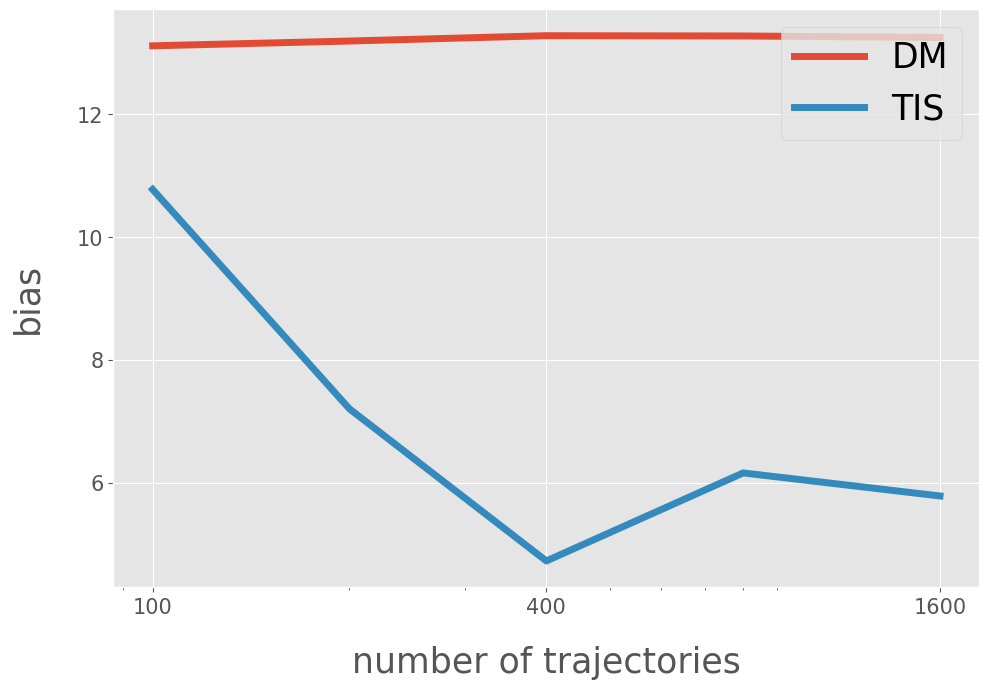

In [57]:
# figure configs
# query = "(est == 'DM' or est == 'IPS') and num_data <= 6400"
xlabels = [100, 400, 1600]

plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(10, 7), tight_layout=True)
sns.lineplot(
    linewidth=5,
    dashes=False,
    legend=False,
    x="n_trajectories",
    y="bias",
    hue="index",
    ax=ax,
    data=bias_result_df.query("(index == 'dm' or index == 'tis')"),
    ci=None,
)
# title and legend
ax.legend(["DM", "TIS"], loc="upper right", fontsize=25)
# yaxis
# ax.set_yscale("log")
ax.set_ylabel("bias", fontsize=25)
ax.tick_params(axis="y", labelsize=15)
ax.yaxis.set_label_coords(-0.08, 0.5)
# xaxis
ax.set_xscale("log")
ax.set_xlabel("number of trajectories", fontsize=25)
ax.set_xticks(xlabels)
ax.set_xticklabels(xlabels, fontsize=15)
ax.xaxis.set_label_coords(0.5, -0.1)

/var/folders/48/ly7vft814qv_x6krlfw5s8_c0000gn/T/ipykernel_40835/132179728.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(


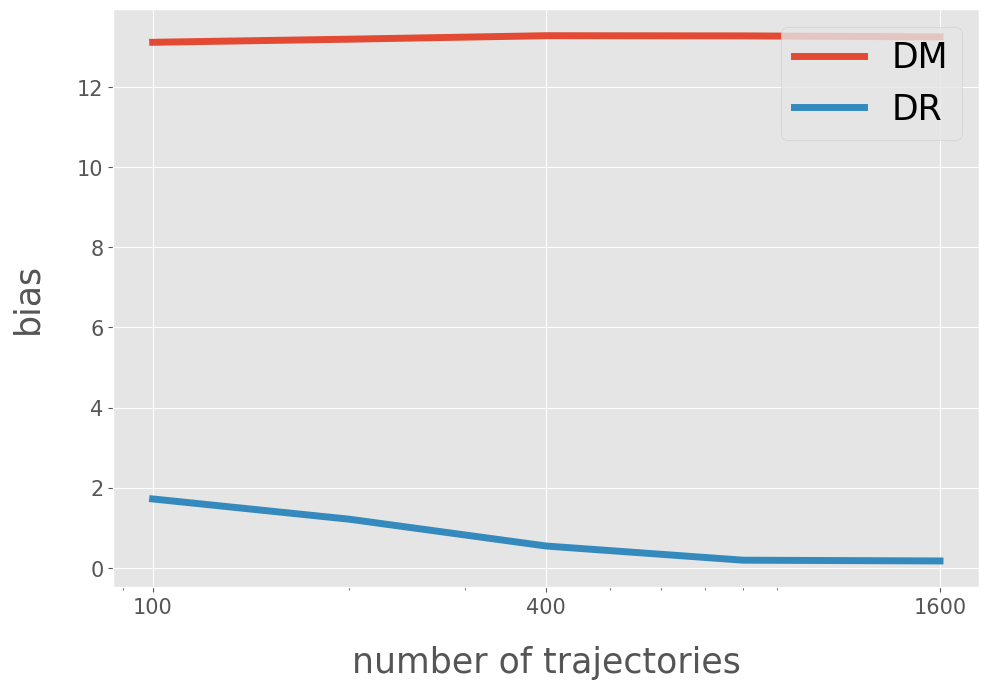

In [56]:
# figure configs
# query = "(est == 'DM' or est == 'IPS') and num_data <= 6400"
xlabels = [100, 400, 1600]

plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(10, 7), tight_layout=True)
sns.lineplot(
    linewidth=5,
    dashes=False,
    legend=False,
    x="n_trajectories",
    y="bias",
    hue="index",
    ax=ax,
    data=bias_result_df.query("(index == 'dm' or index == 'dr')"),
    ci=None,
)
# title and legend
ax.legend(["DM", "DR"], loc="upper right", fontsize=25)
# yaxis
# ax.set_yscale("log")
ax.set_ylabel("bias", fontsize=25)
ax.tick_params(axis="y", labelsize=15)
ax.yaxis.set_label_coords(-0.08, 0.5)
# xaxis
ax.set_xscale("log")
ax.set_xlabel("number of trajectories", fontsize=25)
ax.set_xticks(xlabels)
ax.set_xticklabels(xlabels, fontsize=15)
ax.xaxis.set_label_coords(0.5, -0.1)

In [50]:
variance_result_df

,index,est,bias,n_trajectories
0,on_policy,0,1.533342e-01,100
1,dm,0,1.894362e-02,100
2,tis,0,2.137155e+01,100
3,pdis,0,3.416889e+01,100
4,dr,0,3.458439e+01,100
...,...,...,...,...
80,sam_is,0,4.876359e-07,1600
81,sam_dr,0,1.904789e-02,1600
82,sam_snis,0,3.098709e+01,1600
83,sam_sndr,0,3.161783e+01,1600


In [ ]:
# figure configs
# query = "(est == 'DM' or est == 'IPS') and num_data <= 6400"
xlabels = [100, 400, 1600]

plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(10, 7), tight_layout=True)
sns.lineplot(
    linewidth=5,
    dashes=False,
    legend=False,
    x="n_trajectories",
    y="variance",
    hue="index",
    ax=ax,
    data=variance_result_df.query("(index == 'dm' or index == 'tis')"),
    ci=None,
)
# title and legend
ax.legend(["DM", "TIS"], loc="upper right", fontsize=25)
# yaxis
# ax.set_yscale("log")
ax.set_ylabel("variance", fontsize=25)
ax.tick_params(axis="y", labelsize=15)
ax.yaxis.set_label_coords(-0.08, 0.5)
# xaxis
ax.set_xscale("log")
ax.set_xlabel("number of trajectories", fontsize=25)
ax.set_xticks(xlabels)
ax.set_xticklabels(xlabels, fontsize=15)
ax.xaxis.set_label_coords(0.5, -0.1)

In [ ]:
# figure configs
# query = "(est == 'DM' or est == 'IPS') and num_data <= 6400"
xlabels = [100, 400, 1600]

plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(10, 7), tight_layout=True)
sns.lineplot(
    linewidth=5,
    dashes=False,
    legend=False,
    x="n_trajectories",
    y="variance",
    hue="index",
    ax=ax,
    data=variance_result_df.query("(index == 'tis' or index == 'pdis')")
,
)
# title and legend
ax.legend(["TIS", "PDIS"], loc="upper right", fontsize=25)
# yaxis
# ax.set_yscale("log")
ax.set_ylabel("variance", fontsize=25)
ax.tick_params(axis="y", labelsize=15)
ax.yaxis.set_label_coords(-0.08, 0.5)
# xaxis
ax.set_xscale("log")
ax.set_xlabel("number of trajectories", fontsize=25)
ax.set_xticks(xlabels)
ax.set_xticklabels(xlabels, fontsize=15)
ax.xaxis.set_label_coords(0.5, -0.1)

In [ ]:
# figure configs
# query = "(est == 'DM' or est == 'IPS') and num_data <= 6400"
xlabels = [100, 400, 1600]

plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(10, 7), tight_layout=True)
sns.lineplot(
    linewidth=5,
    dashes=False,
    legend=False,
    x="n_trajectories",
    y="variance",
    hue="index",
    ax=ax,
    data=variance_result_df.query("(index == 'pdis' or index == 'dr')")
,
)
# title and legend
ax.legend(["PDIS", "DR"], loc="upper right", fontsize=25)
# yaxis
# ax.set_yscale("log")
ax.set_ylabel("variance", fontsize=25)
ax.tick_params(axis="y", labelsize=15)
ax.yaxis.set_label_coords(-0.08, 0.5)
# xaxis
ax.set_xscale("log")
ax.set_xlabel("number of trajectories", fontsize=25)
ax.set_xticks(xlabels)
ax.set_xticklabels(xlabels, fontsize=15)
ax.xaxis.set_label_coords(0.5, -0.1)